# New York is Burning
Project Description

## Intro
Import initial libraries.

In [164]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
from datetime import datetime

Read the data set

In [165]:
df = pd.read_csv("weather_data.csv")[["DATE", "TMAX", "TMIN",]]
df = df.copy()

Fill na, and group monthly and yearly.

In [166]:
df["DATE"] = df["DATE"].apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))
df.index = df["DATE"]
df.drop(columns="DATE", inplace=True)
df["TMAX"].fillna(method="ffill", inplace=True)
df["TMIN"].fillna(method="ffill", inplace=True)
monthly_df = df.groupby(pd.Grouper(freq="M")).mean()
yearly_df = df.groupby(pd.Grouper(freq="Y")).mean()

## Decomposing Seasonally
define lag and diff. plot the results

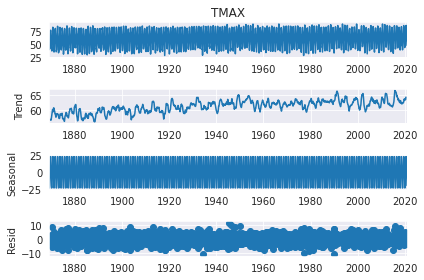

In [167]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(monthly_df["TMAX"], model="additive")
result.plot()
plt.show()

### Create Lag and Diff

In [168]:
monthly_df["tmax_lag1"] = monthly_df["TMAX"].shift(1)
monthly_df["tmax_diff1"] = monthly_df["TMAX"].diff(periods=1)

monthly_df.dropna(inplace=True)

### Train Test Split

In [169]:
train_size = int(monthly_df.shape[0] * 0.9)
train = monthly_df[:train_size]
test = monthly_df[train_size:]

X_train, y_train = train["tmax_lag1"], train["TMAX"]
X_test, y_test = test["tmax_lag1"], test["TMAX"]

calculate base prediction mean absolute error.

## Monthly Analysis

### Base Model

In [ ]:
predictions = X_test.copy()

In [170]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, predictions)
print(mae)

8.06212888116643


plot the base prediction.

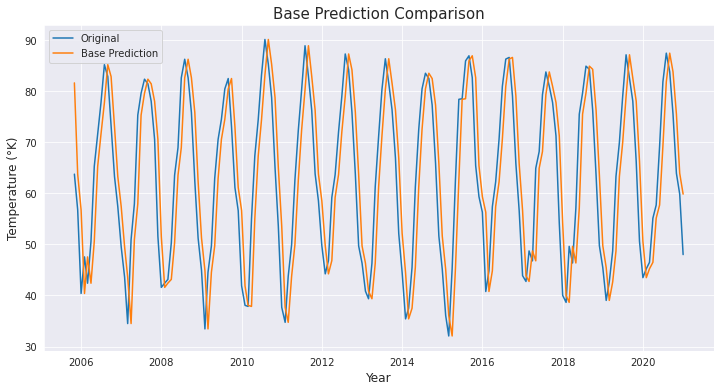

In [171]:
fig = plt.subplots(figsize=(12, 6))
sns.lineplot(x=y_test.index, y=y_test.values, label="Original")
sns.lineplot(x=predictions.index, y=predictions.values, label="Base Prediction")
plt.legend(loc="upper left")
plt.title("Base Prediction Comparison", fontsize=15)
plt.ylabel("Temperature (°K)", fontsize=12)
plt.xlabel("Year", fontsize=12)
plt.show()

### Auto Regression Model

Define the model

In [172]:
from statsmodels.tsa.ar_model import AutoReg

model = AutoReg(train["TMAX"], lags=50)
model_fit = model.fit()

we have the following parameters values.

In [173]:
print(model_fit.params)

const       7.798599
TMAX.L1     0.254080
TMAX.L2     0.044075
TMAX.L3     0.003002
TMAX.L4     0.047581
TMAX.L5    -0.051167
TMAX.L6     0.033627
TMAX.L7     0.030467
TMAX.L8    -0.024330
TMAX.L9    -0.001184
TMAX.L10    0.015063
TMAX.L11    0.045191
TMAX.L12    0.087697
TMAX.L13    0.019732
TMAX.L14   -0.011099
TMAX.L15   -0.017787
TMAX.L16   -0.028293
TMAX.L17   -0.031658
TMAX.L18   -0.021106
TMAX.L19    0.017364
TMAX.L20   -0.012457
TMAX.L21   -0.019109
TMAX.L22    0.045800
TMAX.L23    0.022998
TMAX.L24    0.056863
TMAX.L25    0.059537
TMAX.L26    0.053449
TMAX.L27   -0.014704
TMAX.L28    0.037795
TMAX.L29   -0.019174
TMAX.L30    0.000987
TMAX.L31   -0.013128
TMAX.L32    0.001475
TMAX.L33   -0.009555
TMAX.L34    0.037162
TMAX.L35    0.022666
TMAX.L36    0.059464
TMAX.L37    0.041406
TMAX.L38   -0.015811
TMAX.L39   -0.030736
TMAX.L40    0.005094
TMAX.L41   -0.073566
TMAX.L42    0.003213
TMAX.L43   -0.031845
TMAX.L44   -0.026952
TMAX.L45    0.081456
TMAX.L46    0.017536
TMAX.L47    0

we have the following mean absolute error:

In [174]:
predictions = model_fit.predict(start=len(train), end=len(train) + len(test) - 1)

mae = mean_absolute_error(y_test, predictions)
print(mae)

2.7522724172232884


the prediction looks like:

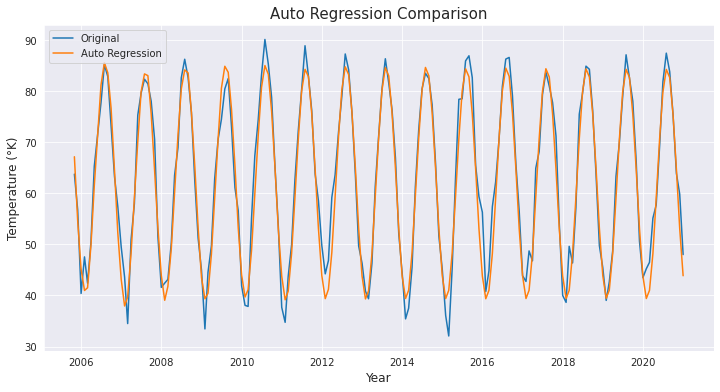

In [175]:
fig = plt.subplots(figsize=(12, 6))
sns.lineplot(x=y_test.index, y=y_test.values, label="Original")
sns.lineplot(x=predictions.index, y=predictions.values, label="Auto Regression")
plt.legend(loc="upper left")
plt.title("Auto Regression Comparison", fontsize=15)
plt.ylabel("Temperature (°K)", fontsize=12)
plt.xlabel("Year", fontsize=12)
plt.show()

### Auto Regression with Walk Forward

define the model.

In [176]:
data = train["TMAX"].copy()
predict = []
for t in test["TMAX"]:
	model = AutoReg(data, lags=50)
	model_fit = model.fit()
	y = model_fit.predict(start=len(data), end=len(train) + len(test) - 1)
	predict.append(y.values[0])
	data = np.append(data, t)
	data = pd.Series(data)

we have the following mean absolute error:

In [177]:
mae = mean_absolute_error(y_test, predict)
print(mae)

2.7988267480661593


and the following graph:

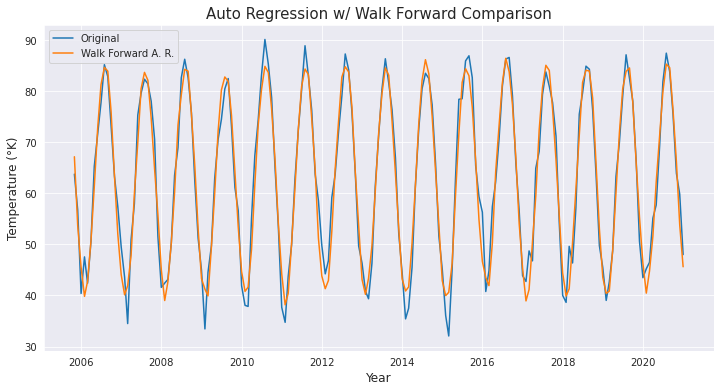

In [178]:
fig = plt.subplots(figsize=(12, 6))
sns.lineplot(x=y_test.index, y=y_test.values, label="Original")
sns.lineplot(x=y_test.index, y=predict, label="Walk Forward A. R.")
plt.legend(loc="upper left")
plt.title("Auto Regression w/ Walk Forward Comparison", fontsize=15)
plt.ylabel("Temperature (°K)", fontsize=12)
plt.xlabel("Year", fontsize=12)
plt.show()

### Moving Average Model

define the model

In [179]:
X_train, y_train = train["tmax_diff1"], train["TMAX"]
X_test, y_test = test["tmax_diff1"], test["TMAX"]

model = AutoReg(train["tmax_diff1"], lags=50)
model_fit = model.fit()

calculate the mean absolute error

In [180]:
pred_resid = model_fit.predict(start=len(train), end=len(train) + len(test) - 1)

predictions = test["tmax_lag1"] + pred_resid
mae = mean_absolute_error(y_test, predictions)
print(mae)

3.353801042003377


plot the predictions

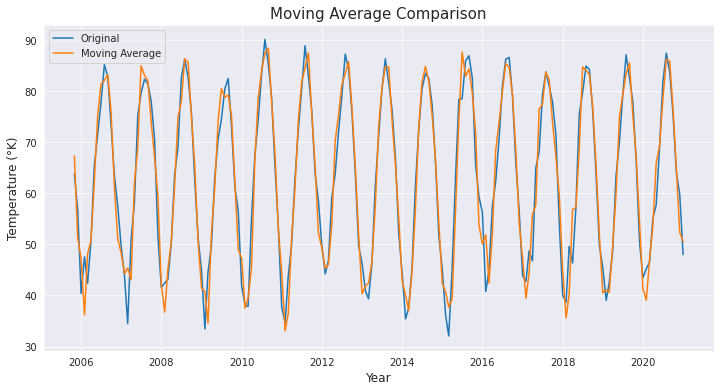

In [181]:
fig = plt.subplots(figsize=(12, 6))
sns.lineplot(x=y_test.index, y=y_test.values, label="Original")
sns.lineplot(x=predictions.index, y=predictions, label="Moving Average")
plt.legend(loc="upper left")
plt.title("Moving Average Comparison", fontsize=15)
plt.ylabel("Temperature (°K)", fontsize=12)
plt.xlabel("Year", fontsize=12)
plt.show()

### Moving Average with Walk Forward

define the model

In [182]:
data = train["tmax_diff1"].copy()
predict = []
for i, t in enumerate(test["tmax_diff1"]):
	model = AutoReg(data, lags=50)
	model_fit = model.fit()
	pred_resid = model_fit.predict(start=len(data), end=len(train) + len(test) - 1)
	pred_resid = pd.Series(index=test.index[i:], data=pred_resid.values)
	y = test["tmax_lag1"][i:] + pred_resid
	predict.append(y.values[0])
	data = np.append(data, t)
	data = pd.Series(data)

calculate the mean absolute error

In [183]:
mae = mean_absolute_error(y_test, predict)
print(mae)

2.816613608185418


plot the results

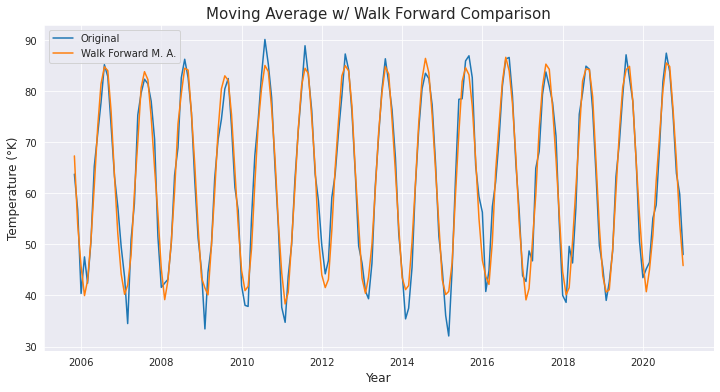

In [184]:
fig = plt.subplots(figsize=(12, 6))
sns.lineplot(x=y_test.index, y=y_test.values, label="Original")
sns.lineplot(x=y_test.index, y=predict, label="Walk Forward M. A.")
plt.legend(loc="upper left")
plt.title("Moving Average w/ Walk Forward Comparison", fontsize=15)
plt.ylabel("Temperature (°K)", fontsize=12)
plt.xlabel("Year", fontsize=12)
plt.show()

### SARIMAX Model

In [185]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(monthly_df["TMAX"], order=(1, 2, 10), seasonal_order=(1, 1, 1, 12))
model_fit = model.fit(maxiter=100, disp=0)

/home/cris/miniconda3/envs/data/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


plot the residuals

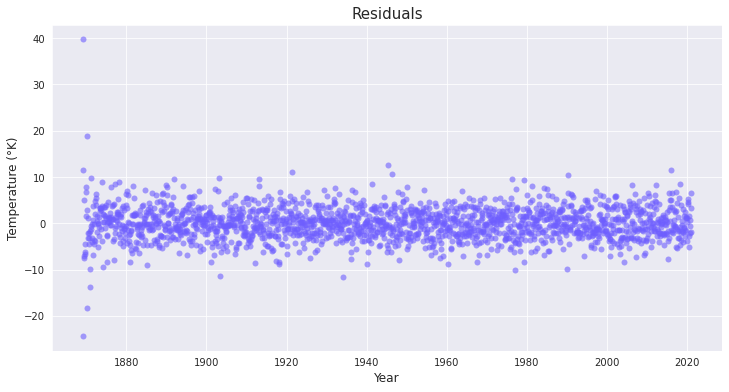

In [186]:
residuals = model_fit.resid
# residuals.plot()

fig = plt.subplots(figsize=(12, 6))
sns.scatterplot(x=residuals.index, y=residuals.values, linewidth=0, alpha=0.6,
                color="#6E5EFF")
plt.title("Residuals", fontsize=15)
plt.ylabel("Temperature (°K)", fontsize=12)
plt.xlabel("Year", fontsize=12)
plt.show()

calculate the mean absolute error on the test set.

In [187]:
yhat = model_fit.predict()
mae = mean_absolute_error(y_test, yhat[-len(y_test):])
print(mae)

2.6585377956258873


We see that the better score is achieved by the SARIMAX model.


we plot the sarimax temperature prediction to compare with the original

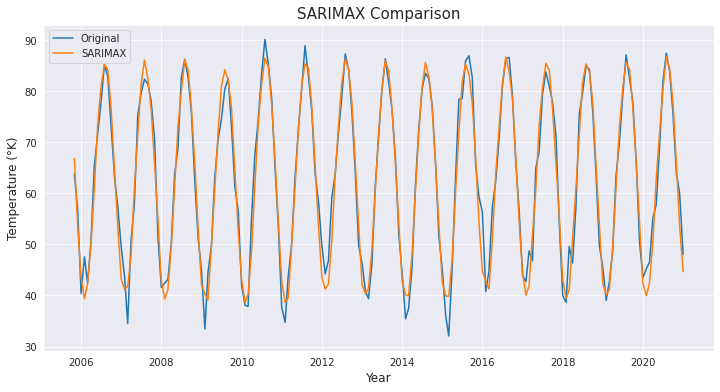

In [188]:
fig = plt.subplots(figsize=(12, 6))
sns.lineplot(x=y_test.index, y=y_test.values, label="Original")
sns.lineplot(x=yhat[-len(y_test):].index, y=yhat[-len(y_test):].values, label="SARIMAX")
plt.legend(loc="upper left")
plt.title("SARIMAX Comparison", fontsize=15)
plt.ylabel("Temperature (°K)", fontsize=12)
plt.xlabel("Year", fontsize=12)
plt.show()

## Yearly Analysis

In [189]:
yearly_yhat = yhat.groupby(pd.Grouper(freq="Y")).mean()
yearly_mae = mean_absolute_error(yearly_df["TMAX"], yearly_yhat)
print(yearly_mae)

0.742651705385053


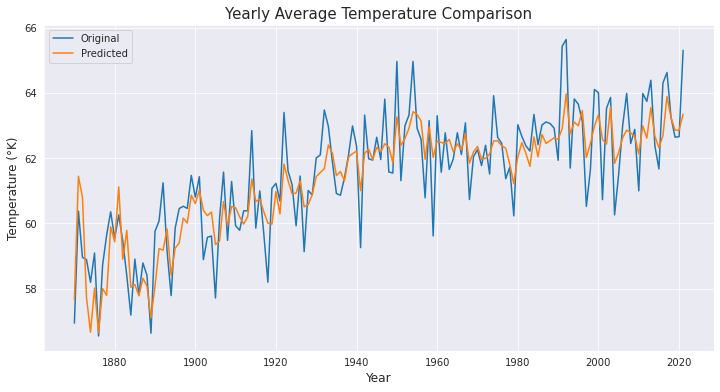

In [190]:
fig = plt.subplots(figsize=(12, 6))
sns.lineplot(x=yearly_df["TMAX"].index, y=yearly_df["TMAX"].values, label="Original")
sns.lineplot(x=yearly_yhat.index, y=yearly_yhat.values, label="Predicted")
plt.legend(loc="upper left")
plt.title("Yearly Average Temperature Comparison", fontsize=15)
plt.ylabel("Temperature (°K)", fontsize=12)
plt.xlabel("Year", fontsize=12)
plt.show()

### Predictions

make 100 years prediction

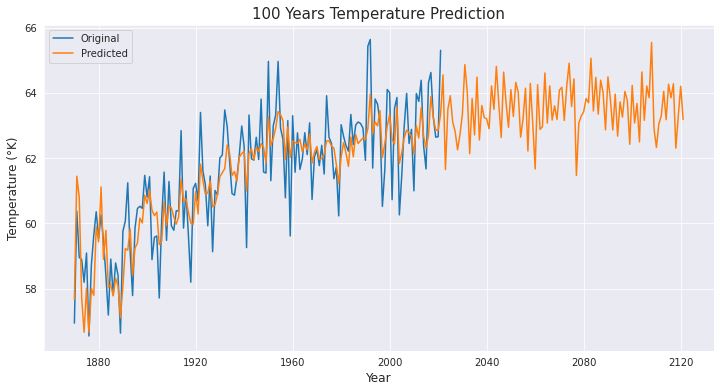

In [191]:
output = model_fit.forecast(1200)
errors = pd.Series(index=output.index,
				   data=np.random.normal(loc=0, scale=mae, size=1200))
output = output + errors
predictions = pd.concat([yhat, output], axis=0)
yearly_predictions = predictions.groupby(pd.Grouper(freq="Y")).mean()

fig = plt.subplots(figsize=(12, 6))
sns.lineplot(x=yearly_df["TMAX"].index, y=yearly_df["TMAX"].values, label="Original")
sns.lineplot(x=yearly_predictions.index, y=yearly_predictions.values, label="Predicted")
plt.legend(loc="upper left")
plt.title("100 Years Temperature Prediction", fontsize=15)
plt.ylabel("Temperature (°K)", fontsize=12)
plt.xlabel("Year", fontsize=12)
plt.show()